# Tutorial - Deep Supervised Learning: Multilayer Perceptron and CNN

In this tutorial lesson, we will try to classify the 
<a href='https://en.wikipedia.org/wiki/MNIST_database'>MNIST dataset</a> model using two different 
network achitectures:
- A multilayer poerceptron made only of linear layers
- A CNN network made of two convolutional layers and two pooling layers before feeding data through fully connected hidden layers. 

## Perform standard imports

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F          # adds some efficiency
from torch.utils.data import DataLoader  # lets us load data in batches
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix  # for evaluating results
import matplotlib.pyplot as plt
%matplotlib inline

If you get an error while loading some package, you can install it now. 

Example: To install torchvision you should run in a cell the following code:<br>
<pre>
!pip install torchvision</pre>

## Load the MNIST dataset

### Define transform
As part of the loading process, we can apply multiple transformations (reshape, convert to tensor, normalize, etc.) to the incoming data.<br>For this exercise we only need to convert images to tensors. 

In [6]:
transform = transforms.ToTensor()

### Load the training set

In [8]:
train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transform)
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

### Load the test set
There's a companion set of MNIST data containing 10,000 records accessible by setting train=False. As before, torchvision will only download this once, and in the future will look for the local copy.

In [9]:
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transform)
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

### Examine the training data

Calling the one of the <tt>train_data</tt> returns a two-item tuple. The first item is our 28x28 tensor representing the image. The second is the label of the image.

**EXERCISE**: Call the first 5 items in the training data and visualize the image and the correct label.

Shape: torch.Size([1, 28, 28]) 
Label: 5


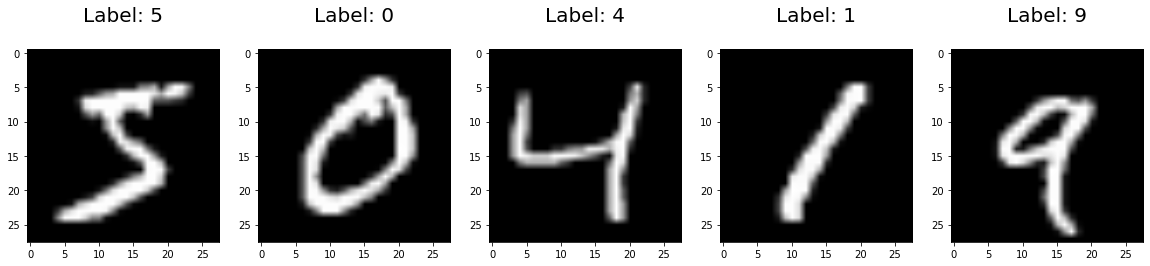

## Batch loading with DataLoader

Our model will be training a large number of parameters for each training epoch (see below).

For this reason it makes sense to load training data in batches using the DataLoader

In [109]:
torch.manual_seed(10)  # for consistent results

train_loader = DataLoader(train_data, batch_size=100, shuffle=True)

test_loader = DataLoader(test_data, batch_size=500, shuffle=False)

### What is the DataLoader doing?


In [110]:
for images,labels in train_loader: 
    break

In [111]:
images.shape

torch.Size([100, 1, 28, 28])

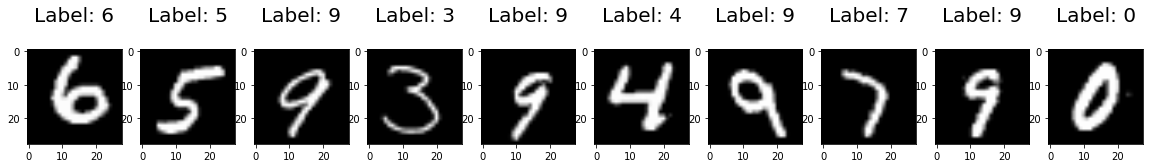

In [112]:
n_images = 10
plt.figure(figsize=(20,n_images))
for index in range(n_images):
    image, label = images[index], labels[index]
    plt.subplot(1, n_images, index + 1)
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray, interpolation='bilinear')
    plt.title('Label: %i\n' % label, fontsize = 20);

# MULTIPLAYER PERCEPTRON

## Define the model
- Our input size is 784 once we flatten the incoming 28x28 tensors.<br>
- Our output size represents the 10 possible digits.<br>
- We'll set our hidden layers to [120, 84] for now. Once you've completed the exercise feel free to come back and try different values.

In [113]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, in_sz=784, out_sz=10, layers=[120,84]):
        super().__init__()
        self.fc1 = nn.Linear(in_sz,layers[0])
        self.fc2 = nn.Linear(layers[0],layers[1])
        self.fc3 = nn.Linear(layers[1],out_sz)
    
    def forward(self,X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [114]:
torch.manual_seed(101)  # set the seed for reproducibility
model = MultilayerPerceptron()
model

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## Count the model parameters
This optional step shows that the number of trainable parameters in our model matches the equation above.

In [115]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [116]:
count_parameters(model)

 94080
   120
 10080
    84
   840
    10
______
105214


## Define loss function & optimizer

In [117]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train the model
This time we'll run the test data through the model during each epoch, so that we can compare loss & accuracy on the same plot.

Before starting the training we need two more ingredients:

1. **Flatten the training data**. This can be done using: images.view(100,-1).size() if image is the original batch of size torch.Size([100, 1, 28, 28]).

2. **Generate predictions**. This can be done using the function torch.max(). 
This functions returns a tensor of maximum values, and a tensor of the indices where the max values were found. In our code we're asking for the index positions of the maximum values along dimension 1.



**QUESTION** : if the shape of my original batch images is tensor is torch.Size([100, 1, 28, 28]), 
what do  I obtain when I do images.view(100,-1).size() ?

In [118]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train.view(100, -1))  # Here we flatten X_train
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{100*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(100*b):7.3f}%')
    
    # Update train loss & accuracy for the epoch
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test.view(500, -1))  # Here we flatten X_test

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
    
    # Update test loss & accuracy for the epoch
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch:  200 [ 20000/60000]  loss: 0.30946583  accuracy:  83.585%
epoch:  0  batch:  400 [ 40000/60000]  loss: 0.16791898  accuracy:  87.945%
epoch:  0  batch:  600 [ 60000/60000]  loss: 0.14138493  accuracy:  89.788%
epoch:  1  batch:  200 [ 20000/60000]  loss: 0.22795954  accuracy:  94.960%
epoch:  1  batch:  400 [ 40000/60000]  loss: 0.25164887  accuracy:  95.183%
epoch:  1  batch:  600 [ 60000/60000]  loss: 0.13384344  accuracy:  95.418%
epoch:  2  batch:  200 [ 20000/60000]  loss: 0.15869433  accuracy:  96.600%
epoch:  2  batch:  400 [ 40000/60000]  loss: 0.07899339  accuracy:  96.665%
epoch:  2  batch:  600 [ 60000/60000]  loss: 0.07815254  accuracy:  96.738%
epoch:  3  batch:  200 [ 20000/60000]  loss: 0.15009280  accuracy:  97.380%
epoch:  3  batch:  400 [ 40000/60000]  loss: 0.19472069  accuracy:  97.395%
epoch:  3  batch:  600 [ 60000/60000]  loss: 0.02258850  accuracy:  97.452%
epoch:  4  batch:  200 [ 20000/60000]  loss: 0.07287324  accuracy:  98.180%
epoch:  4  b

**EXERCISE**:  Plot the loss and accuracy comparisons

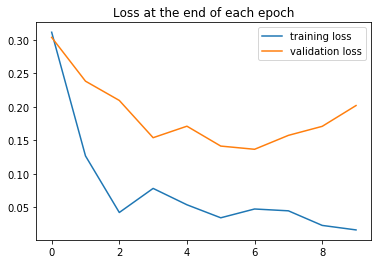

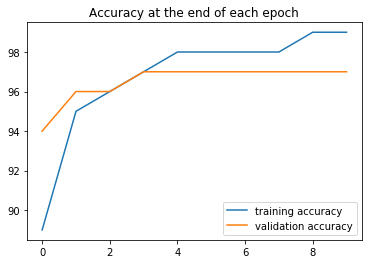

**QUESTION** : how good our model is fitting the data?

## Evaluate Test Data


**EXERCISE**: Extract the data all at once (not in batches) and compute the model accuracy


In [52]:
# Extract the data all at once, not in batches
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [53]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test.view(len(X_test), -1))  # pass in a flattened view of X_test
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9785/10000 =  97.850%


## Display the confusion matrix
This uses scikit-learn, and the predicted values obtained above.

In [54]:
# print a row of values for reference
#np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 973    0    4    0    1    2    5    1    1    1]
 [   0 1125    2    0    0    1    3    4    1    2]
 [   0    2 1007    3    0    0    3    9    2    0]
 [   1    4    4  993    1   13    0    2   11    5]
 [   0    0    2    0  961    2    2    0    5    8]
 [   1    0    0    3    0  865    6    0    5    4]
 [   1    1    2    0    7    2  937    0    1    0]
 [   0    0    5    6    2    0    0 1005    6    6]
 [   3    3    5    2    0    5    2    1  936    0]
 [   1    0    1    3   10    2    0    6    6  983]]


**QUESTION**: in which classes the model perform the better? And in which the worst?

## Examine the misses
We can track the index positions of "missed" predictions, and extract the corresponding image and label. We'll do this in batches to save screen space.

In [56]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')

215

**EXERCISE**:
1. Display the number of misses
2. Plot the first 10 misses, indicating both the correct labe and prediction on the plot

In [ ]:
# Display the number of misses


In [57]:
# Display the first 10 index positions


array([ 115,  149,  217,  247,  321,  340,  381,  445,  449,  495])

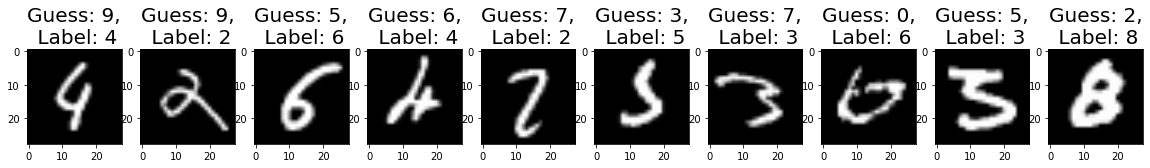

In [67]:
# Plot the first 10 misclassified digits
    

# CONVOLUTIONAL NEURAL NETWORK

## Define a convolutional model

- The model has 2 convolutional layers and 2 fully connected layers
- The first convolutional layer has one input channel (the grayscale color channel). We use 6 convolutional filters of size  3x3 and we set the step size to 1.
- The second convolutional layer has 6 input channels. We use 16 convolutional filters of size 3x3 and we set the step size to 1.
- After both convolutional layers we will apply max pooling using a 2x2 window slided in step of 2.
- After the 2 convolution we will flatten the result to a vector of size 5x5x16 (the number 5 comes from the fact of applying the kernel twice, and applying pooling layers twice, so our resulting output is (((28−2)/2)−2)/2=5.5 which rounds down to 5 pixels per side.
- The we will use 2 fully connected layers with respectively 120 and 84 hidden units.

In [78]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 5*5*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

Let us examine our network better

In [79]:
# Define layers
conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)

In [80]:
# Grab the first MNIST record
for i, (X_train, y_train) in enumerate(train_data):
    break
# Create a rank-4 tensor to be passed into the model
# (train_loader will have done this already)
x = X_train.view(1,1,28,28)
print(x.shape)

torch.Size([1, 1, 28, 28])


In [81]:
# Perform the first convolution/activation
x = F.relu(conv1(x))
print(x.shape)

torch.Size([1, 6, 26, 26])


In [82]:
# Run the first pooling layer
x = F.max_pool2d(x, 2, 2)
print(x.shape)

torch.Size([1, 6, 13, 13])


In [83]:
# Perform the second convolution/activation
x = F.relu(conv2(x))
print(x.shape)

torch.Size([1, 16, 11, 11])


In [84]:
# Run the second pooling layer
x = F.max_pool2d(x, 2, 2)
print(x.shape)

torch.Size([1, 16, 5, 5])


In [85]:
# Flatten the data
x = x.view(-1, 5*5*16)
print(x.shape)

torch.Size([1, 400])


### Count the number of parameters

In [86]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [88]:
count_parameters(model)

    54
     6
   864
    16
 48000
   120
 10080
    84
   840
    10
______
 60074


### Define loss and optimizer
We use the same loss function and optimizer as for the Multilayer Perceptron.

In [90]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Create loaders
When working with images, we want relatively small batches

In [91]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

## Train the model

**EXERCISE** Create a loop to train the model. 
This time we'll feed the data directly into the model without flattening it first.

In [92]:
import time
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        #------------------------------------------#
        # YOUR CODE HERE
        # Apply the model
     
 
        # Save the number of correct predictions

        
        # Update parameters
        
        #------------------------------------------#
        
        # Print interim results
        if b%600 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch:  600 [  6000/60000]  loss: 0.48589650  accuracy:  78.400%
epoch:  0  batch: 1200 [ 12000/60000]  loss: 0.09464751  accuracy:  85.333%
epoch:  0  batch: 1800 [ 18000/60000]  loss: 0.02404689  accuracy:  88.461%
epoch:  0  batch: 2400 [ 24000/60000]  loss: 0.06765813  accuracy:  90.208%
epoch:  0  batch: 3000 [ 30000/60000]  loss: 0.00376188  accuracy:  91.427%
epoch:  0  batch: 3600 [ 36000/60000]  loss: 0.03269944  accuracy:  92.350%
epoch:  0  batch: 4200 [ 42000/60000]  loss: 0.14003955  accuracy:  92.986%
epoch:  0  batch: 4800 [ 48000/60000]  loss: 0.00421301  accuracy:  93.463%
epoch:  0  batch: 5400 [ 54000/60000]  loss: 0.00118867  accuracy:  93.898%
epoch:  0  batch: 6000 [ 60000/60000]  loss: 0.12278441  accuracy:  94.240%
epoch:  1  batch:  600 [  6000/60000]  loss: 0.02486612  accuracy:  97.650%
epoch:  1  batch: 1200 [ 12000/60000]  loss: 0.00519902  accuracy:  97.842%
epoch:  1  batch: 1800 [ 18000/60000]  loss: 0.05080507  accuracy:  97.922%
epoch:  1  b

**EXERCISE**
- Compare loss and accuracy between training and test data during learning
- Compute the accuracy of the model on test data
- Compute the confusion matrix
- Analyse the misses

### Loss function and accuracy

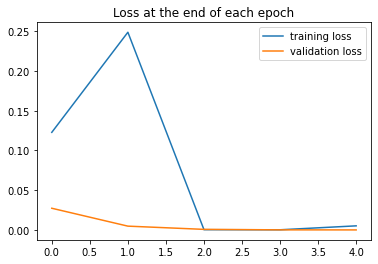

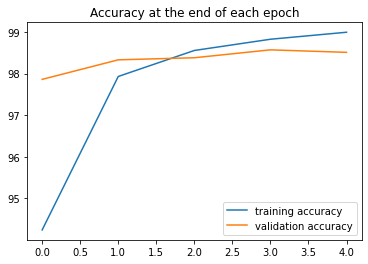

Test accuracy: 9851/10000 =  98.510%


### Confusion matrix

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 974    1    1    0    1    2    4    1    4    0]
 [   0 1124    0    0    1    0    1    3    0    0]
 [   0    1 1005    0    1    0    1    1    0    0]
 [   0    0   11 1004    0    5    0    4    2    2]
 [   0    0    2    0  973    0    2    4    3   13]
 [   0    1    0    4    0  883    4    0    1    8]
 [   4    3    0    0    1    2  945    0    0    0]
 [   1    4   10    0    0    0    0 1006    0    2]
 [   1    1    3    2    4    0    1    4  960    7]
 [   0    0    0    0    1    0    0    5    4  977]]


### Misses

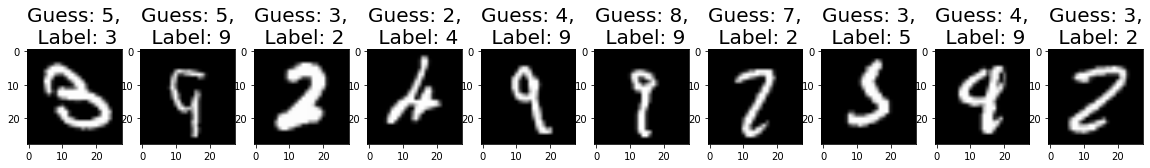

**QUESTIONS** 
- Is the model overfitting the data? Is it performing better than the Multilayer Perceptron?
- How does the misses look like?

## Run a new image through the model

**EXERCISE**: 
- pick a number between 0 and 9999 and generate the prediction of the model for the corresponding test data.
- plot the image with actual label and the model prediction

Predicted value: 2


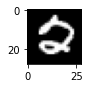

In [102]:
x = 1984 # pick a number between 0 and 9999
